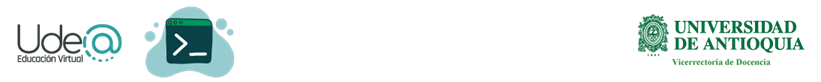

# Laboratorio Regresión Lineal
## Parte B: Regularización, Inferencia y Regresión Bayesiana

**Laboratorio Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

**Autores:**

* Pablo Alejandro Alvarado Duran, PhD.
*   Cristian David Ríos Urrego, MSc.
*   Diana Patricia Tobon Vallejo, PhD.


---

# Sobreentrenamiento

Como vimos en la parte A del laboratorio de regresión lineal, el estimador de máxima verosimilitud es propenso al sobreentrenamiento.

Recordemos la definición del modelo que establece la correspondencia entre los datos de entrada $\textbf{x}_n$ con los datos de salida $y_n$

$$
\begin{align}
y_n &= f(\textbf{x}_n, \boldsymbol{\theta}) + \epsilon, \\
y_n &= \sum_{k = 0}^K \theta_k \phi_k(\textbf{x}_n) + \epsilon,
\end{align}
$$

donde los datos de entrada son $\textbf{x}_n \in \mathbb{R}^D$, y los datos de salida corresponden a $ y_n \in \mathbb{R}$.

In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt

Iniciemos generando una base de datos sintética

In [2]:
# generar base de datos sintética
np.random.seed(0)
Ntrain = 25 # número de observaciones
Ntest = 1000 # cantidad datos de entrenamiento

sigma = 0.05 # desviación estandar del ruido
Xtrain = np.linspace(-3, 3, Ntrain).reshape(-1, 1) # datos de entrada
ytrain = np.sinc(Xtrain) + np.random.normal(size=(Xtrain.shape), scale=sigma) # datos de salida

Xtest = np.linspace(-3, 3, Ntest).reshape(-1, 1) # datos de entrada
ytest= np.sinc(Xtest)

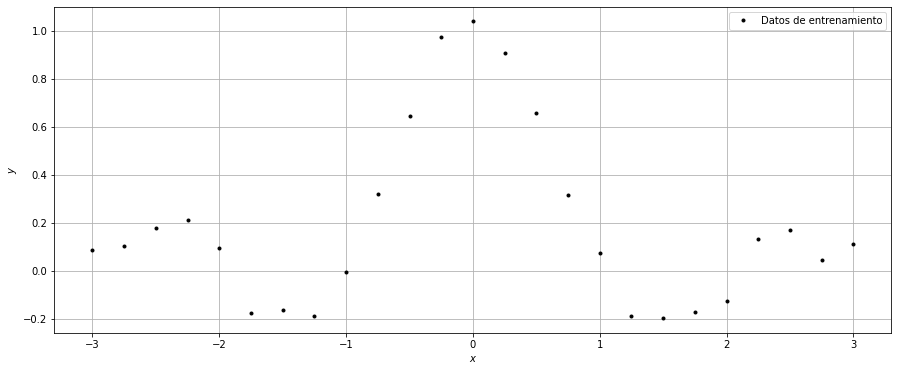

In [3]:
plt.figure(figsize=(15,6))
plt.plot(Xtrain, ytrain, '.k')
plt.xlabel("$x$")
plt.ylabel("$y$");
plt.legend(['Datos de entrenamiento']);
plt.grid()
plt.show()

Seguiremos usando el modelo de regresión con características polinomiales, es decir:

# Características polinomiales

Si asumimos $D=1$, entonces $\textbf x = x$. Además, $\phi_k(x) = x^k$ Por lo tanto, un polinomio de grado $K$ estaría definido como

$$
\begin{align}
f(x, \boldsymbol \theta) &= \sum_{k=0}^K \theta_k x^k, \\
%
&= \boldsymbol \phi(x)^\top\boldsymbol\theta,
\end{align}
$$

donde

$$
 \boldsymbol\phi(x)
 =
 \begin{bmatrix}
 \phi_0(x)\\
 \phi_1(x)\\
 \vdots\\
 \phi_K(x)
 \end{bmatrix}
 =
 \begin{bmatrix}
 x^0\\
 x^1\\
 \vdots\\
 x^K
 \end{bmatrix}
 \in \mathbb R^{K+1}.
$$

Es decir, $\boldsymbol\phi(x)$ es un vector que contiene todas transformaciones no lineales aplicadas sobre la entrada $x$. Agrupando para todos los datos $N$ se obtiene la matriz

$$
\boldsymbol\Phi =
\begin{bmatrix}
\boldsymbol\phi(x_1)^\top & \boldsymbol\phi(x_2)^\top & \cdots & \boldsymbol\phi(x_N)^\top
\end{bmatrix}
\in \mathbb R^{N \times (K+1)}.
$$

Por lo tanto,

$$
\textbf{y} = \boldsymbol \Phi \boldsymbol \theta
$$

In [4]:
def poli_carac(X, K):
    # Extraer caracteristicas polinomiales
    # X: N x D, vector de entradas
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi

    X = X.flatten()
    N = X.shape[0]

    #inicializar Phi
    Phi = np.zeros((N, K+1))

    # Calcular matriz Phi
    for k in range(K+1):
        Phi[:,k] = X**k
    return Phi

In [5]:
def plot_prediccion(X, prediccion):
    # Gráfica predicción
    plt.plot(X, np.sinc(X), lw=2, label='función real')
    plt.plot(X, prediccion, '-', lw=2, label='predicción')
    plt.plot(Xtrain, ytrain, '.k', label='datos entre.')
    # plt.xlabel("$x$")
    # plt.ylabel("$y$")
    plt.legend()
    plt.ylim([-0.3, 1.1])

# Máxima verosimilitud

### Inferencia usando extracción de caracteristicas

Si utilizamos funciones base (carácteristicas) los parámetros óptimos se calculan con la siguiente expresión

$$
\boldsymbol \theta^\text{MV} = (\boldsymbol\Phi^\top\boldsymbol\Phi)^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

> Por motivos de estabilidad, es una práctica común adicionar un valor pequeño llamado "jitter" $\kappa>0$ en la diagonal de $\boldsymbol\Phi^\top\boldsymbol\Phi$, de manera que podamos invertir esta matriz sin problemas. Los parámetros óptimos se calculan entonces con la expresión

$$
\boldsymbol \theta^\text{MV} = (\boldsymbol\Phi^\top\boldsymbol\Phi + \kappa\textbf{I})^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

In [6]:
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados

    kappa = 1e-09 # jitter
    D = Phi.shape[1]

    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y
    #theta_ml = sp.linalg.solve(PP, Pt)
    return theta_ml

In [7]:
def rmse(y, y_pred):
    # Calculo función de error
    y = y.flatten()
    y_pred = y_pred.flatten()
    N = y.shape[0]
    difer = (y - y_pred)**2
    return np.sqrt((1.0/N) * np.sum(difer))

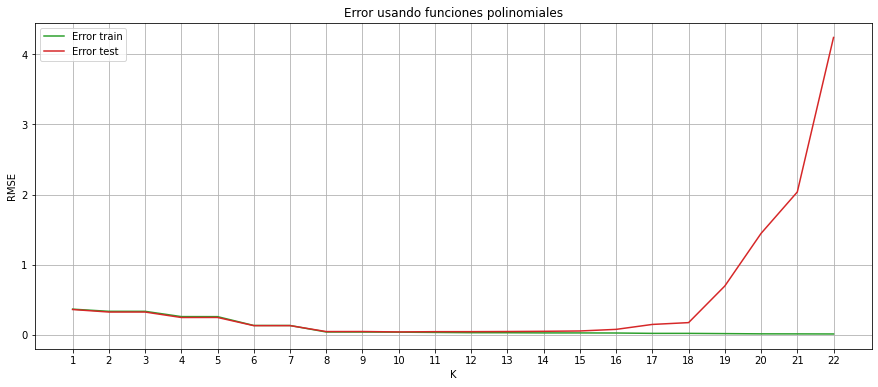

In [8]:
rmse_train = []
rmse_test = []
carac = poli_carac # seleccionar tipo de caracteristicas (poli, expo, cos)
K_max = 23 # cantidad máxima de caracteristicas


for i in range(1, K_max):
    # selección y parametrización
    K = i # grado del polinomio
    Phi = carac(Xtrain, K)

    # inferencia usando max vero
    theta_ml = inferencia_max_vero_carac(Phi, ytrain)

    # predicción sobre datos de entrenamiento
    Phi_test = carac(Xtrain, K)
    y_pred = Phi_test @ theta_ml # predicción
    rmse_train.append(rmse(ytrain, y_pred)) # medir error

    # predicción sobre datos de test
    Phi_test = carac(Xtest, K)
    y_pred = Phi_test @ theta_ml # predicción
    rmse_test.append(rmse(ytest, y_pred)) # medir error

# graficar errores
k_vector = np.linspace(1,K,K)

plt.figure(figsize=(15,6))
plt.plot(k_vector, rmse_train, 'C2-', label='Error train')
plt.plot(k_vector, rmse_test, 'C3-', label='Error test')
plt.xticks(k_vector);
plt.ylabel('RMSE')
plt.xlabel('K')
plt.title('Error usando funciones polinomiales')
plt.legend()
plt.grid()

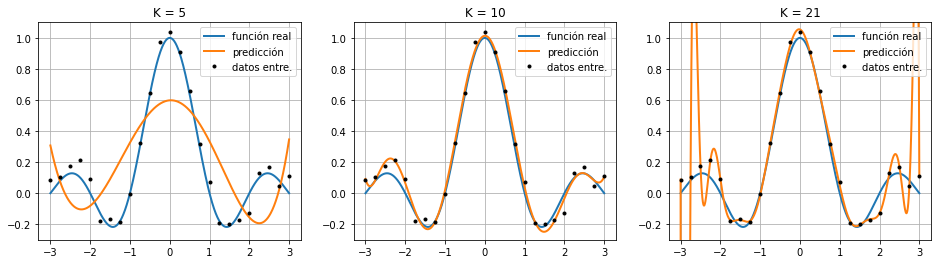

In [9]:
k_values = [5, 10, 21]
plt.figure(figsize=(16,4))
for i in range(3):
    K = k_values[i]
    Phi = poli_carac(Xtrain, K) # características datos entrenamiento
    theta_ml = inferencia_max_vero_carac(Phi, ytrain)

    Phi_test = poli_carac(Xtest, K) # características todos los datos
    y_pred = Phi_test @ theta_ml # predicción

    # graficar resultados
    plt.subplot(1,3,i+1)
    plot_prediccion(Xtest, y_pred)
    plt.title('K = ' + str(K));
    plt.grid()

$K = 4$ (underfitting) sub entrenamiento

$K = 10$ (best fit) generalización adecuada

$K = 19$ (overfitting) sobreentrenamiento

En muchos casos podemos tener información previa sobre los parámetros $\theta$. Por ejemplo, podríamos saber que ciertos coeficientes deberían estar cerca de cero o dentro de un rango específico basado en estudios previos o conocimientos teóricos. Para incorporar esta información adicional, utilizamos la estimación a partir de máximo a posteriori (MAP).


# Máximo a posteriori (MAP)

Acabamos de ver que la estimación de máxima verosimilitud es propensa al sobreajuste. A menudo observamos que la magnitud de los valores de los parámetros se hace relativamente grande si nos encontramos con un sobreajuste. Para mitigar el efecto de los enormes valores de los parámetros, podemos colocar una distribución a priori $p(θ)$ en los parámetros. La distribución a priori codifica explícitamente qué valores de los parámetros son plausibles (antes de haber visto ningún dato).

Por lo tanto, dado un conjunto de datos $\mathcal Y|\mathcal X$ en lugar de maximizar la verosimilitud buscamos parámetros que maximicen la distribución posterior $p(\boldsymbol\theta|\mathcal X, \mathcal Y)$. Este procedimiento se denomina estimación máxima a posteriori (MAP) y aplicando el teorema de Bayes lo definimos como:

$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \frac{\overbrace{p(\mathcal Y|\mathcal X, \boldsymbol\theta)}^{\text{likelihood}}\overbrace{p(\boldsymbol\theta)}^{\text{prior}}}{\underbrace{p(\mathcal Y|\mathcal X)}_{\text{evidence}}}
$$

El propósito del prior $p(\boldsymbol\theta)$ es reducir la tendencia a que los parámetros tengan valores muy grandes, lo cual es un indicio de sobreentrenamiento. . Normalmente se escoge un prior Gaussiano $\mathcal N(\boldsymbol 0, \alpha^2\boldsymbol I)$ centrado en el origen con determinada varianza $\alpha^2$.

La estimación con MAP corresponde a

$$
\boldsymbol\theta^{\text{MAP}} = (\boldsymbol\Phi^T\boldsymbol\Phi + \frac{\sigma^2}{\alpha^2}\textbf{I})^{-1}\boldsymbol\Phi^T \textbf{y}
$$

donde $\sigma^2$ es la varianza del ruido.

Recordando el concepto de máxima verosimilitud:

$$
\boldsymbol \theta^\text{MLE} = (\boldsymbol\Phi^\top\boldsymbol\Phi + \kappa\textbf{I})^{-1}\boldsymbol\Phi^\top \textbf{y}
$$

Observamos que la unica diferencia es que $\kappa = \frac{\sigma^2}{\alpha^2}$, este termino garantiza que se pueda calcular la inversa de la matriz, pero también controla los valores que toman los parámetros en el proceso de inferencia, con el propósito de generar mejores predicciones en los datos de Test, este proceso se conoce como **regularización**.

In [10]:
def inferencia_max_posterior_carac(Phi, y, sigma, alpha):
    # Phi: N x D, características de entrada
    # y: D x 1, datos de salida
    # sigma: escalar, desviación estandar del ruido
    # alpha: escalar, desviación estandar del prior sobre los parámetros
    # return: D x 1,  estimación MAP theta_map

    D = Phi.shape[1]

    # SOLUTION
    PP = Phi.T @ Phi + (sigma/alpha)**2 * np.eye(D)
    theta_map = sp.linalg.solve(PP, Phi.T @ y)

    return theta_map

In [11]:
# get the MAP estimate
K = 12 # polynomial degree

alpha = 0.25 # standard deviation of the parameter prior

# feature matrix
Phi = poli_carac(Xtrain, K)

theta_map = inferencia_max_posterior_carac(Phi, ytrain, sigma, alpha)

# maximum likelihood estimate
theta_ml = inferencia_max_vero_carac(Phi, ytrain)


Phi_test = poli_carac(Xtest, K)

y_pred_map = Phi_test @ theta_map
y_pred_mv = Phi_test @ theta_ml

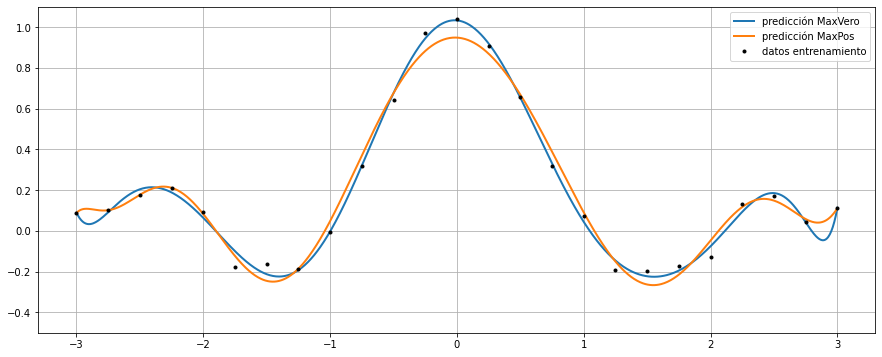

In [12]:
plt.figure(figsize=(15,6))
plt.plot(Xtest, y_pred_mv, lw=2)
plt.plot(Xtest, y_pred_map, lw=2)
plt.plot(Xtrain, ytrain, '.k')
plt.legend(["predicción MaxVero", "predicción MaxPos", "datos entrenamiento"]);
plt.ylim([-0.5, 1.1])
plt.grid()

Ahora, calculemos el error RMSE para diferentes valores de $K$, y observemos si la estimación MAP reduce el sobreentrenamiento que presenta la inferencia por máxima verosimilitud.



/home/cristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: LinAlgWarning: Ill-conditioned matrix (rcond=6.75938e-17): result may not be accurate.
  if sys.path[0] == '':
/home/cristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: LinAlgWarning: Ill-conditioned matrix (rcond=7.32524e-18): result may not be accurate.
  if sys.path[0] == '':
/home/cristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: LinAlgWarning: Ill-conditioned matrix (rcond=7.52785e-19): result may not be accurate.
  if sys.path[0] == '':
/home/cristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: LinAlgWarning: Ill-conditioned matrix (rcond=8.43764e-20): result may not be accurate.
  if sys.path[0] == '':
/home/cristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: LinAlgWarning: Ill-conditioned matrix (rcond=1.15521e-20): result may not be accurate.
  if sys.path[0] == '':
/home/cristian/anaconda3/lib/python3.7/site-packag

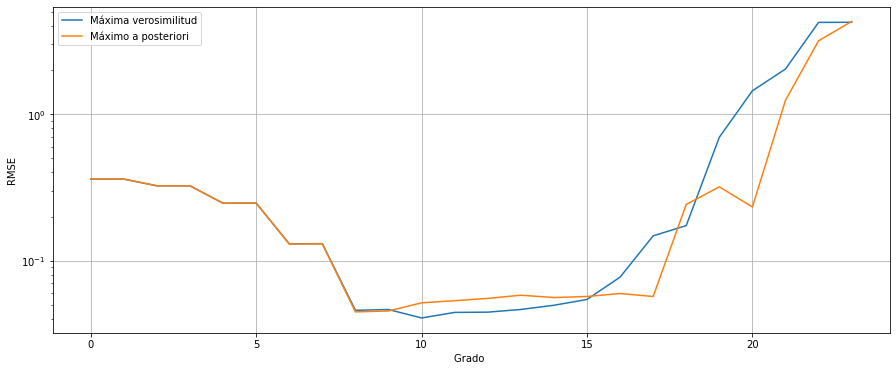

In [13]:
## EDIT THIS CELL

K_max = 23 # this is the maximum degree of polynomial we will consider

rmse_mle = np.zeros((K_max+1,))
rmse_map = np.zeros((K_max+1,))

for k in range(K_max+1):

    # feature matrix
    Phi = poli_carac(Xtrain, k)

    # maximum likelihood estimate
    theta_ml = inferencia_max_vero_carac(Phi, ytrain)

    # predict the function values at the test input locations (maximum likelihood)

    ####################### SOLUTION
    # feature matrix for test inputs
    Phi_test = poli_carac(Xtest, k)

    # prediction
    ypred_test_mle = Phi_test @ theta_ml
    #######################

    # RMSE on test set (maximum likelihood)
    rmse_mle[k] = rmse(ytest, ypred_test_mle)

    # MAP estimate
    theta_map = inferencia_max_posterior_carac(Phi, ytrain, sigma, alpha)

    # Feature matrix
    Phi_test = poli_carac(Xtest, k)

    # predict the function values at the test input locations (MAP)
    ypred_test_map = Phi_test @ theta_map

    # RMSE on test set (MAP)
    rmse_map[k] = rmse(ytest, ypred_test_map)

plt.figure(figsize=(15,6))
plt.semilogy(rmse_mle) # this plots the RMSE on a logarithmic scale
plt.semilogy(rmse_map) # this plots the RMSE on a logarithmic scale
plt.xlabel("Grado ")
plt.ylabel("RMSE")
plt.legend(["Máxima verosimilitud", "Máximo a posteriori"])
plt.grid()

Observamos que los modelos de regresión lineal en los que estimamos los parámetros del modelo $\theta$ mediante estimación de máxima verosimilitud o máximo a posteriori puede dar lugar a un sobreajuste grave (principalmente MLE), en particular, en el régimen de datos pequeños. MAP aborda este problema agregando un priori $p(θ)$ en los parámetros que desempeña el papel de un regularizador.

Ahora pensemos porque no llevar la idea del parámetro a priori un paso más allá y no calcular una estimación puntual de los parámetros, sino tener en cuenta toda la distribución posterior de los parámetros a la hora de hacer predicciones (agregar incertidumbre). Esto significa que no ajustamos ningún parámetro, sino que calculamos una media de todos los parámetros (según la distribución posterior), este concepto es introducido a continuación y se define como **Regresión lineal Bayesiana**.

# Regresión lineal Bayesiana



En esta sección, hablaremos de la regresión lineal bayesiana, en la que utilizamos la inferencia bayesiana para encontrar una distribución posterior sobre los parámetros desconocidos, que posteriormente utilizamos para hacer predicciones. Más concretamente, para las predicciones promediaremos todos los conjuntos plausibles de parámetros en lugar de centrarnos en una estimación puntual.



En regresión lineal Bayesiana se considera el siguiente modelo, definiendo el prior sobre los parámetros y la verosimilitud:

$$p(\boldsymbol \theta) = \mathcal{N}(\textbf{m}_0, \textbf{S}_0),$$

$$p(y|x, \boldsymbol{\theta}) = \mathcal{N}(y|\boldsymbol{\phi}^{\top}(x)\boldsymbol{\theta}, \sigma^2),$$

El posterior sobre los parámetros corresponde a
$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \frac{\overbrace{p(\mathcal Y|\mathcal X, \boldsymbol\theta)}^{\text{likelihood}}\overbrace{p(\boldsymbol\theta)}^{\text{prior}}}{\underbrace{p(\mathcal Y|\mathcal X)}_{\text{evidence}}}
$$,

es decir
$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \mathcal{N}(\boldsymbol\theta|\textbf{m}_N, \textbf{S}_N),
$$

con

$$
\textbf{S}_N = (\textbf{S}_0^{-1} + \sigma^{-2} \boldsymbol{\Phi}^{\top}\boldsymbol{\Phi})^{-1},
$$

y

$$
\textbf{m}_N =
\textbf{S}_N(\textbf{S}_0^{-1}\textbf{m}_0 + \sigma^{-2} \boldsymbol{\Phi}^{\top}\textbf{y}).
$$


Estas ecuaciones nos representan la manera de como calcular el prior $p(\boldsymbol \theta)$ a partir de un conjunto de entrenamiento ($\mathcal X, \mathcal Y$). En otras palabras, partimos de que los parámetros $\boldsymbol \theta$ tienen una distribución normal con media $\textbf{m}_0$ y covarianza $\textbf{S}_0$. Luego, combinando la información del prior y la verosimilitud, obtenemos el posterior, que es una nueva distribución normal con media $\textbf{m}_N$ y covarianza $\textbf{S}_N$. Esta distribución nos da una estimación actualizada de los parámetros $p(\boldsymbol \theta)$ después de observar los datos $\mathcal X, \mathcal Y$.

In [14]:
sigma = 0.05 # desviación estandar del ruido
prior_var = 1.0 # variance of the parameter prior (alpha^2). We assume this is known.
noise_var = sigma**2 # noise variance (sigma^2). We assume this is known.

pol_deg = 10 # degree of the polynomial we consider at the moment

Asumiendo un prior sobre los parámetros de la forma

$$p(\boldsymbol\theta) = \mathcal N (\boldsymbol 0, \alpha^2\boldsymbol I)$$,

para cada dato de test $\boldsymbol x_*$ se obtiene la siguiente media predictiva

$$
E[f(\boldsymbol x_*)] = 0.
$$

Asimismo, la varianza predictiva inicial corresponde a (ignorando la varianza del ruido)

$$
V[f(\boldsymbol x_*)] = \alpha^2\boldsymbol\phi(\boldsymbol x_*) \boldsymbol\phi(\boldsymbol x_*)^\top
$$

donde $\boldsymbol\phi(\cdot)$ son las características o funciones base escogidas, para este caso funciones polinomiales.

En este proceso se está estableciendo una base de cómo se comportará la predicción antes de observar los datos, asumiendo un modelo previo sobre los parámetros y las características de los datos.

In [15]:
def plot_distribution(x, media, var):
    # graficar media e intervalo de confianza

    x = x.flatten()
    media = media.flatten()
    var = var.flatten()
    conf = 2.0*np.sqrt(var) # intervalo de confianza

    plt.figure(figsize=(15,6))
    plt.plot(x, media, color="C0")
    plt.fill_between(x, media + conf, media - conf, alpha = 0.1, color="C0")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.grid()

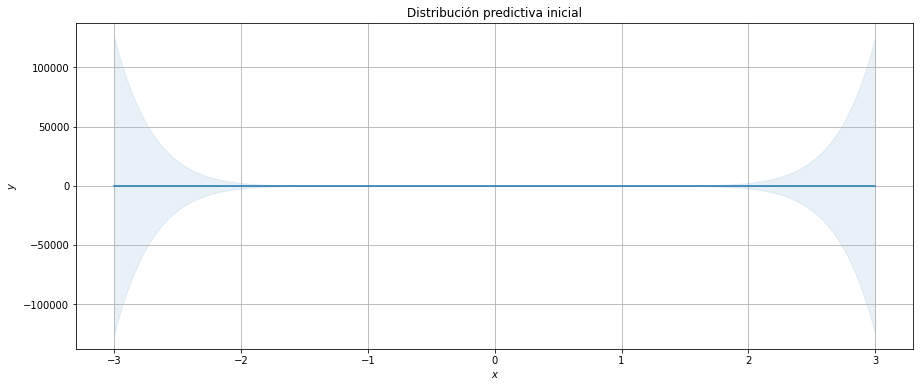

In [16]:
# compute the feature matrix for the test inputs
Phi_test = poli_carac(Xtest, pol_deg) # N x (pol_deg+1) feature matrix SOLUTION

# compute the (marginal) prior at the test input locations
# prior mean
prior_mean = np.zeros((Ntest,1)) # prior mean <-- SOLUTION

# prior variance
full_covariance = Phi_test @ Phi_test.T * prior_var # N x N covariance matrix of all function values
prior_marginal_var =  np.diag(full_covariance)

plot_distribution(Xtest, prior_mean, prior_marginal_var)

plt.title("Distribución predictiva inicial");

Esta imagen muestra la **distribución predictiva inicial** de un modelo de regresión bayesiana antes de observar cualquier dato, en otras palabras, "funciones solución" del problema de regresión.

La línea azul central en la gráfica representa la media predictiva $E[f(\boldsymbol x_*)]$. En este caso, dado el prior asumido con media cero, la media predictiva es cero para todos los valores de $x$.

La banda sombreada alrededor de la línea azul muestra la varianza predictiva $V[f(\boldsymbol x_*)]$. Esta varianza nos da una medida de la incertidumbre del modelo en sus predicciones para diferentes valores de $x$. En la gráfica, esta varianza aumenta a medida que nos alejamos del origen ($x = 0$).

Por lo tanto, la gráfica ilustra cómo la distribución inicial de las predicciones es más precisa (menor varianza) cerca de $x=0$ y se vuelve más incierta (mayor varianza) a medida que $x$ se aleja de cero. Esto tiene sentido dado a que estamos usando funciones base polinomiales y la varianza de la predicción se expande debido al crecimiento de las características polinomiales a medida que $x$ se aleja del origen.


Cada función muestreada es un polinomio de grado 10


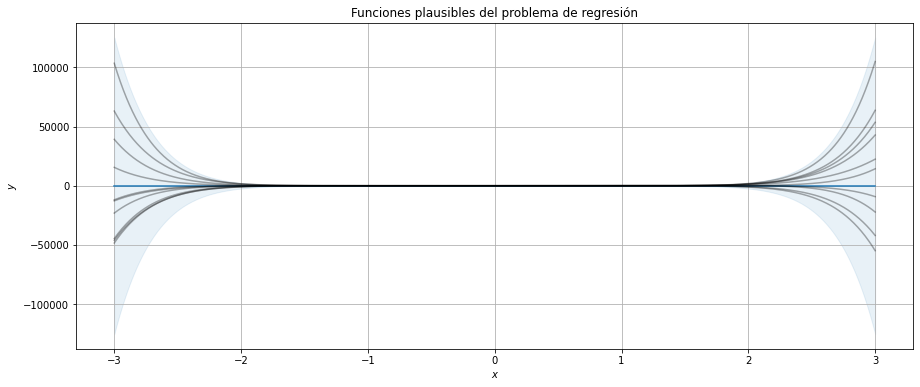

In [17]:
## EDIT THIS CELL

# samples from the prior
num_samples = 10

# We first need to generate random weights theta_i, which we sample from the parameter prior
random_weights = np.random.normal(size=(pol_deg+1,num_samples),
                                  scale=np.sqrt(prior_var))

# Now, we compute the induced random functions, evaluated at the test input locations
# Every function sample is given as f_i = Phi * theta_i,
# where theta_i is a sample from the parameter prior

sample_function = Phi_test @ random_weights # <-- SOLUTION

plot_distribution(Xtest, prior_mean, prior_marginal_var)
plt.plot(Xtest, sample_function, color="k", alpha=0.33)
plt.title("Funciones plausibles del problema de regresión")
print("Cada función muestreada es un polinomio de grado "+str(pol_deg));

Recordemos que la linea azul y el sombreado representa la distribución predictiva inicial de nuestro modelo de regresión Bayesiana. Ahora, cada una de las lineas negras representa una **función solución** del problema de regresión, generada aleatoriamente. En otras palabras, el gráfico muestra diferentes posibles funciones que el modelo de regresión bayesiana podría considerar plausibles antes de ajustar el modelo a datos reales.

Finalmente, una vez establecido el modelo podemos unificarlo con la base de datos que tengamos a disposición, y calcular la distribución posterior sobre el modelo $f$

$$
\boldsymbol x_1, \dotsc, \boldsymbol x_N
$$,

$$
\boldsymbol X = [\boldsymbol x_1, \dotsc, \boldsymbol x_N]^\top\in\mathbb{R}^{N\times D}
$$.

In [18]:
## EDIT THIS FUNCTION

def polyfit(X, y, K, prior_var, noise_var):
    # X: training inputs, size N x D
    # y: training targets, size N x 1
    # K: degree of polynomial we consider
    # prior_var: prior variance of the parameter distribution
    # sigma: noise variance

    jitter = 1e-08 # increases numerical stability

    Phi = poli_carac(X, K) # N x (K+1) feature matrix

    # Compute maximum likelihood estimate
    Pt = Phi.T @ y # Phi*y, size (K+1,1)
    PP = Phi.T @ Phi + jitter*np.eye(K+1) # size (K+1, K+1)
    C = sp.linalg.cho_factor(PP)
    # maximum likelihood estimate
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

#     theta_ml = scipy.linalg.solve(PP, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)

    # MAP estimate
    theta_map = sp.linalg.solve(PP + noise_var/prior_var*np.eye(K+1), Pt)

    # parameter posterior
    iSN = (np.eye(K+1)/prior_var + PP/noise_var) # posterior precision
    SN = sp.linalg.pinv(noise_var*np.eye(K+1)/prior_var + PP)*noise_var  # posterior covariance
    mN = sp.linalg.solve(iSN, Pt/noise_var) # posterior mean

    return (theta_ml, theta_map, mN, SN)

In [19]:
theta_ml, theta_map, theta_mean, theta_var = polyfit(Xtrain, ytrain, pol_deg, alpha, sigma)

En el caso de regesión lineal Bayesiana, la predicción que obtenemos es una distribución de probabilidad posterior sobre la función $f$ con la que queremos modelar los datos observados, es decir

$$
p(y_*| \mathcal{X},\mathcal{Y}, x_*) =
\mathcal{N}(y_*| \hat{m}, \hat{\sigma}^2 ),
$$

donde

$$
\hat{m} = \boldsymbol{\phi}(x_*)^{\top}\textbf{m}_N,
$$

y

$$
\hat{\sigma}^2 = \boldsymbol{\phi}(x_*)^{\top}\textbf{S}_N\boldsymbol{\phi}(x_*) + \sigma^2.
$$


Finalmente, una vez entrenado el modelo podemos hacer predicciones usando el modelo de regresión lineal Bayesiana:

\begin{align}
\text{Bayesian: } p(f(\boldsymbol X_{\text{test}})) = \mathcal N(f(\boldsymbol X_{\text{test}}) \,|\, \boldsymbol \phi(X_{\text{test}}) \boldsymbol\theta_{\text{mean}},\, \boldsymbol\phi(X_{\text{test}}) \boldsymbol\theta_{\text{var}}  \boldsymbol\phi(X_{\text{test}})^\top)$
\end{align}

In [20]:
## EDIT THIS CELL

# predictions (ignoring the measurement/observations noise)

Phi_test = poli_carac(Xtest, pol_deg) # N x (K+1)

# maximum likelihood predictions (just the mean)
m_mle_test = Phi_test @ theta_ml

# MAP predictions (just the mean)
m_map_test = Phi_test @ theta_map

# predictive distribution (Bayesian linear regression)
# mean prediction
mean_blr = Phi_test @ theta_mean
# variance prediction
cov_blr =  Phi_test @ theta_var @ Phi_test.T

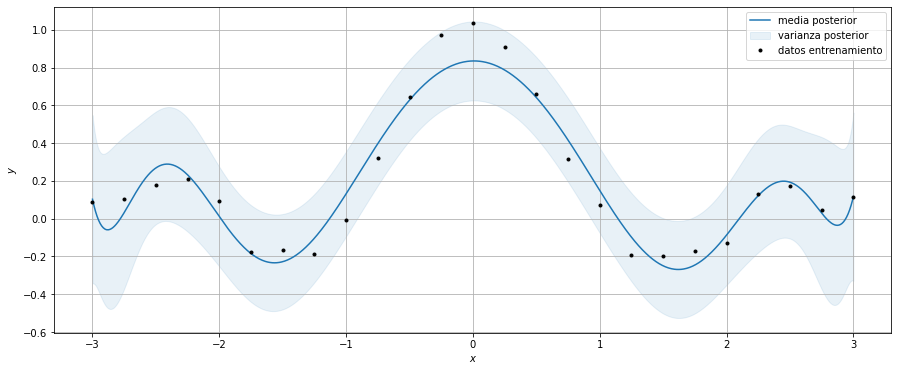

In [21]:
# plot the posterior
plt.figure(figsize=(15,6))
#plt.plot(Xtest, m_mle_test)
plt.plot(Xtest, m_map_test, 'C0')
var_blr = np.diag(cov_blr)

#conf_bound1 = np.sqrt(var_blr).flatten()
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()
#conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()

#plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1, mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2, mean_blr.flatten() - conf_bound2, alpha = 0.1, color="C0")
#plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3, mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")

plt.plot(Xtrain, ytrain, ".k")
plt.legend(["media posterior", "varianza posterior", "datos entrenamiento"])
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.grid()

Recordemos y comparemos Máximo a posteriori, Máxima verosimilitud e Inferencia bayesiana:

\begin{align}
&\text{Maximum likelihood: }E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{ml}\\
&\text{Maximum a posteriori: } E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{map}\\
&\text{Bayesian: } p(f(\boldsymbol X_{\text{test}})) = \mathcal N(f(\boldsymbol X_{\text{test}}) \,|\, \boldsymbol \phi(X_{\text{test}}) \boldsymbol\theta_{\text{mean}},\, \boldsymbol\phi(X_{\text{test}}) \boldsymbol\theta_{\text{var}}  \boldsymbol\phi(X_{\text{test}})^\top)
\end{align}

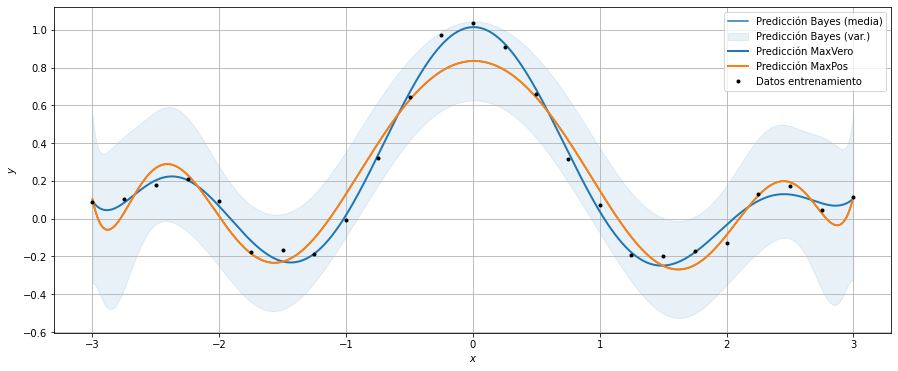

In [23]:
y_pred_map = Phi_test @ theta_map
y_pred_mv = Phi_test @ theta_ml

# plot the posterior
plt.figure(figsize=(15,6))
#plt.plot(Xtest, m_mle_test)
plt.plot(Xtest, m_map_test, 'C0')
var_blr = np.diag(cov_blr)
# conf_bound1 = np.sqrt(var_blr).flatten()
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()
# conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()

# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1,
                #  mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2,
                 mean_blr.flatten() - conf_bound2, alpha = 0.1, color="C0")
# plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3,
                #  mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")
plt.plot(Xtest, y_pred_mv, lw=2)
plt.plot(Xtest, y_pred_map, lw=2)
plt.plot(Xtrain, ytrain, ".k")
plt.legend(["Bayes (media)", "Bayes (var.)", "Máxima verosimilitud", "Máximo a posteriori",   
            "datos entre."])

plt.legend(["Predicción Bayes (media)", "Predicción Bayes (var.)", "Predicción MaxVero", 
            "Predicción MaxPos", "Datos entrenamiento"]);


plt.xlabel('$x$');
plt.ylabel('$y$');
plt.grid()
plt.show()

# Trabajo de laboratorio
Como trabajo de laboratorio vamos a entrenar un modelo de regresión para el caso **univariado** $y_n = f(x_n) + \epsilon$. Llevar a cabo el siguiente procedimiento:

1. Descargar la base de datos ```EET-small``` y visualizar la variable a predecir ```oil temperature``` (https://github.com/zhouhaoyi/ETDataset).

2. Dividir la base de datos en 70% entrenamiento y 30% test, utilizando una partición aleatoria.

3. Utilice las funciones exponenciales como funciones base, y estime los parámetros del modelo utilizando MAP y MLE para diez valores diferentes de $M$ (número de funciónes base).

4. Calcule el MSE entre:

  - la predicción de los modelos y los datos de entrenamiento.
  - la predicción de los modelos y los datos de test.
  
 Visualice ambos errores en una misma gráfica ($M$ vs MSE-MAP y $M$ vs. MSE-MLE). De acuerdo a los resultados obtenidos establezca:
  - ¿Cuál es el número en funciones base $M$ correspondiente al modelo con mejor capacidad de generalización?
  - ¿El MSE entre las predicciónes y los datos de entrenamiento también es mínimo para ese mismo valor de $M$?, argumente.
  - ¿Qué método (MAP o MLE) obtiene un mejor desempeño respecto a número de funciones base vs. el error?, argumente.


5. Por último, utilice regresión lineal Bayesiana y grafique la media posterior y el intervalo de confianza de la distribución predictiva obtenida (use los mismos datos particionados en el punto 2). Utilice diferentes valores para la varianza del prior sobre los parámetros, describa y explique los cambios observados.

# Bibliografía
- Pattern Recognition and Machine Learning, Christopher M. Bishop. https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf (libro original gratis).

- Mathematics for Machine Learning, Marc Peter Deisenroth. https://mml-book.github.io/ (libro original gratis).

- Cuadernos del libro: Mathematics for Machine Learning. https://nbviewer.org/github/mml-book/mml-book.github.io/blob/master/tutorials/tutorial_linear_regression.ipynb